In [6]:
# Installation des dépendances
!pip install ultralytics h5py opencv-python tqdm

In [7]:
# Montage du Drive (pour aller chercher vos fichiers H5 sources)
from google.colab import drive
drive.mount('/content/drive')

import os
# Vérifiez que ce chemin est bon !
SOURCE_DRIVE_PATH = "/content/drive/MyDrive/Colab Notebooks/brain_segmentation/BraTS2020_training_data/content/data/"

if not os.path.exists(SOURCE_DRIVE_PATH):
    print("ATTENTION : Le chemin source semble incorrect. Vérifiez SOURCE_DRIVE_PATH.")
else:
    print(f"Source détectée. Prêt à travailler.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Source détectée. Prêt à travailler.


In [9]:
import h5py
import numpy as np
import cv2
import glob
import random
import shutil
from tqdm import tqdm

# Configuration
OUTPUT_BASE_DIR = "/content/datasets/brats_yolo"

def normalize_channel(channel):
    if np.max(channel) == np.min(channel):
        return np.zeros_like(channel, dtype=np.uint8)
    norm = (channel - np.min(channel)) / (np.max(channel) - np.min(channel))
    return (norm * 255).astype(np.uint8)

def mask_to_polygons(mask, class_id=0):
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    polygons = []
    H, W = mask.shape
    for cnt in contours:
        if cv2.contourArea(cnt) > 20:
            cnt = cnt.flatten()
            relative_coords = []
            for i in range(0, len(cnt), 2):
                x = cnt[i] / W
                y = cnt[i+1] / H
                relative_coords.extend([x, y])
            poly_str = f"{class_id} " + " ".join([f"{n:.6f}" for n in relative_coords])
            polygons.append(poly_str)
    return polygons

def prepare_yolo_dataset():
    if os.path.exists(OUTPUT_BASE_DIR):
        shutil.rmtree(OUTPUT_BASE_DIR) # On nettoie si ça existe déjà

    for split in ['train', 'val']:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'images', split), exist_ok=True)
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, 'labels', split), exist_ok=True)

    print("Lecture des fichiers H5 depuis le Drive...")
    files = glob.glob(os.path.join(SOURCE_DRIVE_PATH, "*.h5"))
    random.shuffle(files)

    # --- IMPORTANT : Pour tester rapidement, on ne prend que 500 images ---
    # Si ça marche, enlevez la ligne ci-dessous pour tout traiter (ça prendra 10-20 min)
    files_to_process = files[:500]

    print(f"Conversion de {len(files_to_process)} fichiers en format YOLO...")

    for i, file_path in enumerate(tqdm(files_to_process)):
        try:
            split = 'train' if i < 0.8 * len(files_to_process) else 'val'
            filename_base = os.path.splitext(os.path.basename(file_path))[0]

            with h5py.File(file_path, 'r') as f:
                img_data = f['image'][:]
                mask_data = f['mask'][:]

                # Création JPG (T1ce + FLAIR + T2)
                c_red = normalize_channel(img_data[:, :, 1])
                c_green = normalize_channel(img_data[:, :, 3])
                c_blue = normalize_channel(img_data[:, :, 2])
                img_rgb = np.dstack((c_blue, c_green, c_red))

                # Sauvegarde Image
                cv2.imwrite(os.path.join(OUTPUT_BASE_DIR, 'images', split, f"{filename_base}.jpg"), img_rgb)

                # Création Label
                mask_combined = np.max(mask_data, axis=2)
                mask_binary = np.where(mask_combined > 0, 1, 0).astype(np.uint8)
                polygons = mask_to_polygons(mask_binary)

                if polygons:
                    with open(os.path.join(OUTPUT_BASE_DIR, 'labels', split, f"{filename_base}.txt"), 'w') as out_f:
                        out_f.write("\n".join(polygons))

        except Exception as e:
            print(f"Erreur: {e}")

    # Création du YAML
    yaml_content = f"""
path: {OUTPUT_BASE_DIR}
train: images/train
val: images/val
names:
  0: tumeur
"""
    with open(os.path.join(OUTPUT_BASE_DIR, "data.yaml"), "w") as f:
        f.write(yaml_content)
    print("\nDataset prêt !")

# Lancer la conversion
prepare_yolo_dataset()

Lecture des fichiers H5 depuis le Drive...
Conversion de 500 fichiers en format YOLO...


100%|██████████| 500/500 [03:32<00:00,  2.36it/s]


Dataset prêt !


In [10]:
from ultralytics import YOLO

# 1. Charger le modèle
model = YOLO('yolov8n-seg.pt')  # Version 'nano' pour que ça aille vite au début

# 2. Entraîner
print("Démarrage de l'entraînement...")

results = model.train(
    data='/content/datasets/brats_yolo/data.yaml', # Le fichier créé par la cellule précédente
    epochs=20,          # 20 époques pour tester
    imgsz=256,          # Taille 256 pour aller vite (mettez 512 plus tard)
    batch=16,
    name='brats_yolo_run',
    device=0            # GPU
)

print("Entraînement terminé !")

Démarrage de l'entraînement...
Ultralytics 8.3.232 🚀 Python-3.12.12 torch-2.9.0+cu126 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/content/datasets/brats_yolo/data.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=256, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n-seg.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=brats_yolo_run2, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=Tru

🔍 Recherche du modèle entraîné...
✅ Modèle trouvé : /content/runs/segment/brats_yolo_run2/weights/best.pt
Test sur l'image : volume_106_slice_13.jpg

image 1/1 /content/datasets/brats_yolo/images/val/volume_106_slice_13.jpg: 256x256 (no detections), 9.3ms
Speed: 0.7ms preprocess, 9.3ms inference, 0.4ms postprocess per image at shape (1, 3, 256, 256)


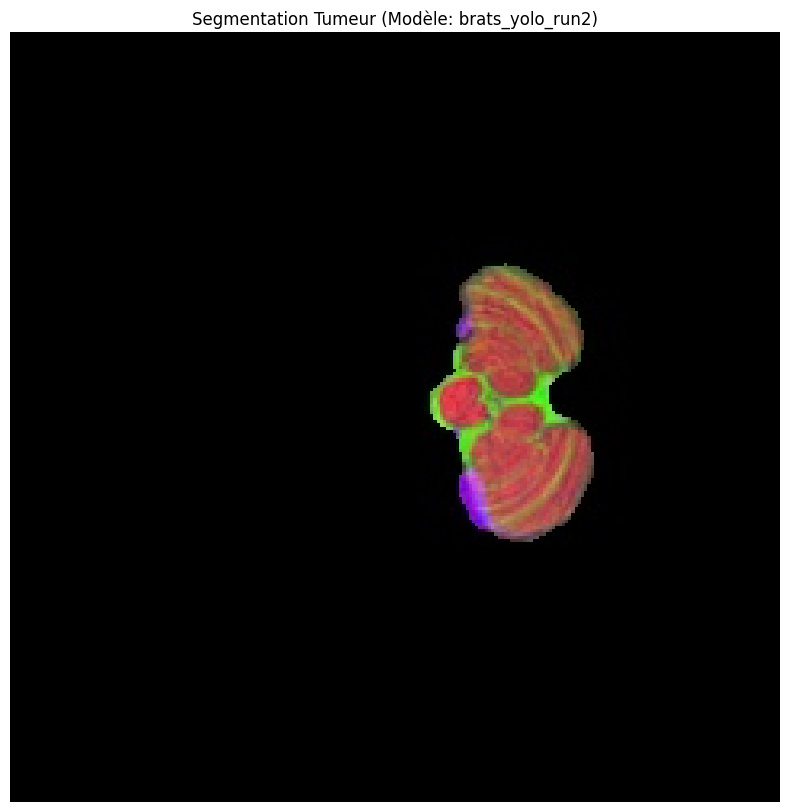

In [12]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
import random
import os

print("🔍 Recherche du modèle entraîné...")

# On cherche le fichier 'best.pt' partout dans le dossier runs
found_models = glob.glob("/content/runs/**/best.pt", recursive=True)

if not found_models:
    print("❌ ERREUR : Aucun fichier 'best.pt' trouvé.")
    print("Causes possibles :")
    print("1. L'entraînement (Cellule 3) a planté avant la fin.")
    print("2. Vous avez redémarré le runtime (ce qui efface les fichiers temporaires).")
else:
    # On prend le dernier modèle trouvé (le plus récent)
    model_path = sorted(found_models)[-1]
    print(f"✅ Modèle trouvé : {model_path}")

    # --- Lancement du test ---
    best_model = YOLO(model_path)

    # Prendre une image de validation au hasard
    val_images = glob.glob("/content/datasets/brats_yolo/images/val/*.jpg")

    if val_images:
        test_img = random.choice(val_images)
        print(f"Test sur l'image : {os.path.basename(test_img)}")

        # Prédiction
        results = best_model.predict(source=test_img, conf=0.25, save=False)

        # Affichage
        if len(results) > 0:
            res_plotted = results[0].plot()
            plt.figure(figsize=(10, 10))
            plt.imshow(cv2.cvtColor(res_plotted, cv2.COLOR_BGR2RGB))
            plt.axis('off')
            plt.title(f"Segmentation Tumeur (Modèle: {os.path.basename(os.path.dirname(os.path.dirname(model_path)))})")
            plt.show()
        else:
            print("Aucun résultat renvoyé par le modèle.")
    else:
        print("⚠️ Pas d'images trouvées dans le dossier validation.")